## 1. Introduction

Churn(고객 이탈)이란 무엇인가?
고객 이탈은 신규 고객을 확보하는 것보다 기존 고객을 유지하는 것이 훨씬 저렴하기 때문에 중요한 지표입니다.
고객 이탈을 줄이기 위해 통신 회사는 어떤 고객이 이탈 위험이 높은지 예측해야 합니다.

이 IBM 데이터셋은 통신사 고객에 대한 정보와 해당 고객이 지난달 내에 서비스를 떠났는지(이탈) 여부가 포함되어 있습니다.

각 데이터에 대한 부연 설명:
Gender 고객의 성별, SeniorCitizen 연령대, Partner 배우자, Dependents 부양 가족의 유무 
PhoneService 전화, MultipleLine 다중 라인, InternetService 인터넷, OnlineSecurity 온라인 보안, OnlineBackup 온라인 백업, DeviceProtection 장치 보호, TechSupport 기술 지원, StreamingTV, StreamingMovies 스트리밍 TV 및 영화
CustomerID 고객 계정, Contract 계약 유형, PaperlessBilling 페이퍼 청구 여부, PaymentMethod 결제 방법, MonthlyCharges 월별 요금, TotalCharges 총 요금, Tenure 얼마나 오래 서비스를 이용했는지(보유도)

In [1]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
filepath = '/kaggle/input/telco-customer-churn/'
df = pd.read_csv(filepath + 'WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col = 'customerID')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [5]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## 2.Data Exploration

In [6]:
# TotalCharges의 데이터가 수치임에도 object타입으로 되어있어 수치형으로 변환
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].dtype

dtype('float64')

In [7]:
# 기술통계 찍을 때 int형이라 같이 출력되어서 categorical 변수이기 때문에 int가 아닌 object형으로 변환
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
df['SeniorCitizen'].dtype

dtype('O')

In [8]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
# 많은 데이터 중 단 11개에만 결측치가 있으므로 결측치는 제거한다.
df = df.dropna() 
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [11]:
df.describe() # numerical 변수만 나온다

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [12]:
df["Churn"].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

In [13]:
df["Churn"].value_counts(normalize=True)

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64

<Axes: xlabel='Churn', ylabel='count'>

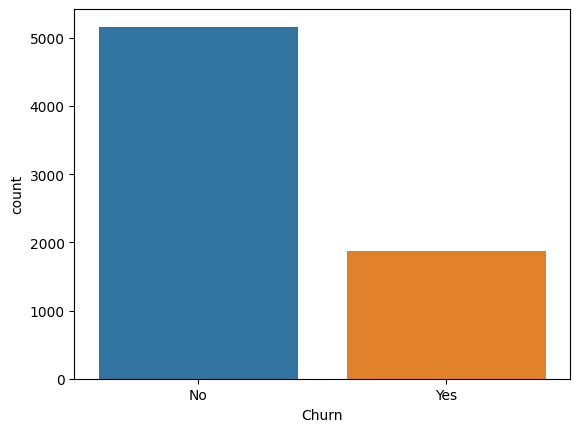

In [14]:
sns.countplot(data=df, x=df["Churn"])

고객의 약27%가 이탈할 예정임.

### 2-1. Numerical features

kde(kernal density estimation) 커널 밀도 추정
https://www.kaggle.com/code/jsaguiar/exploratory-analysis-with-seaborn 참고

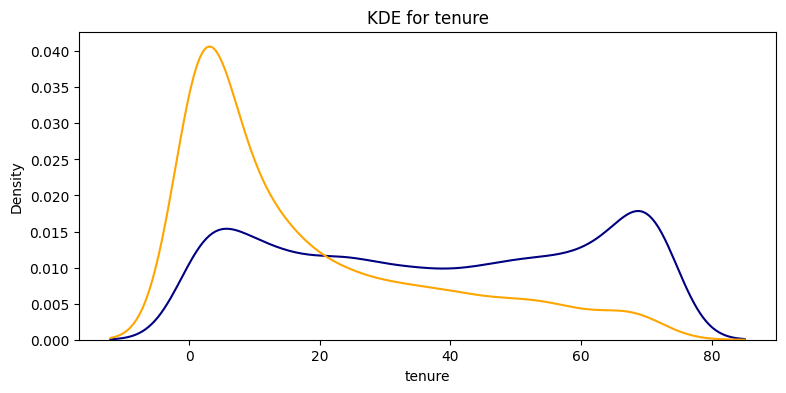

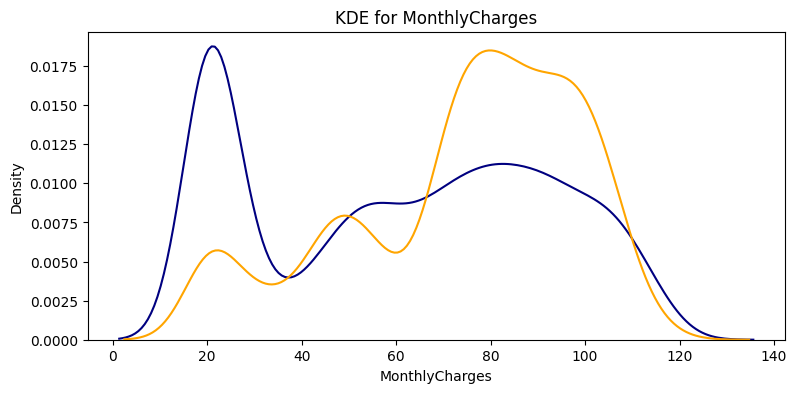

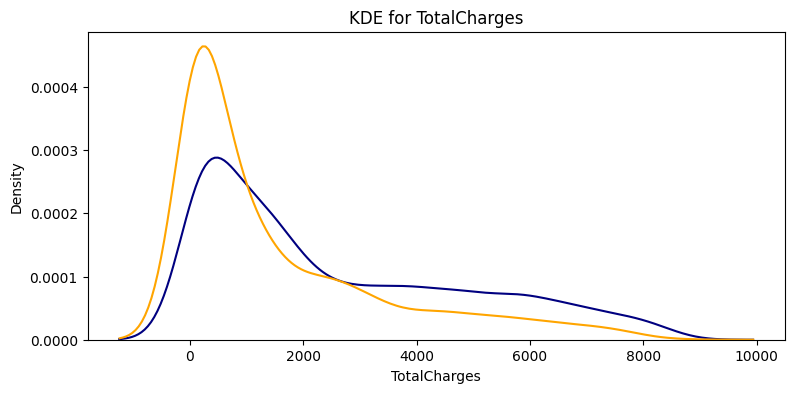

In [15]:
def kdeplot(feature):
    plt.figure(figsize=(9,4))
    plt.title(f"KDE for {feature}")
    ax0 = sns.kdeplot(df[df["Churn"] == "No"][feature].dropna(), color = 'navy', label='Churn: No')
    ax1 = sns.kdeplot(df[df["Churn"] == "Yes"][feature].dropna(), color = 'orange', label='Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

그래프를 통해 알 수 있는 것
- 최근에 유입된 고객일 수록 이탈 가능성이 더 높다.
- 월간 요금이 높은 고객이 이탈 가능성이 더 높다.
- TotalCharges 변수보단 Tenure 와 MonthlyCharges가 더 중요한 feature로 작용한다.

### 2-2. Categorical features

In [16]:
g = df.groupby("gender")["Churn"].value_counts()
g

gender  Churn
Female  No       2544
        Yes       939
Male    No       2619
        Yes       930
Name: count, dtype: int64

In [17]:
g = g.rename("count").reset_index()
g

,gender,Churn,count
0,Female,No,2544
1,Female,Yes,939
2,Male,No,2619
3,Male,Yes,930


In [18]:
g["count"] = g["count"]/len(df)
g["count"]

0    0.361775
1    0.133532
2    0.372440
3    0.132253
Name: count, dtype: float64

<Axes: xlabel='gender', ylabel='count'>

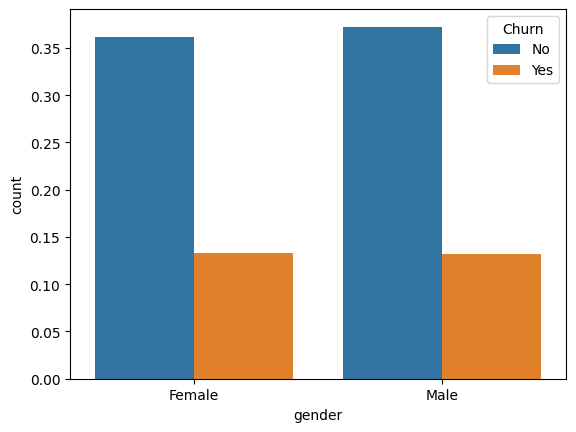

In [19]:
sns.barplot(data=g, x="gender", y="count", hue="Churn")

<Axes: xlabel='SeniorCitizen', ylabel='count'>

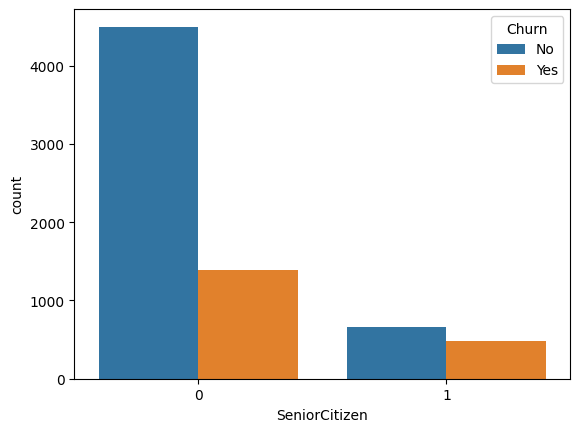

In [20]:
g = df.groupby("SeniorCitizen")["Churn"].value_counts()
g = g.rename("count").reset_index()
sns.barplot(data=g, x="SeniorCitizen", y="count", hue="Churn")

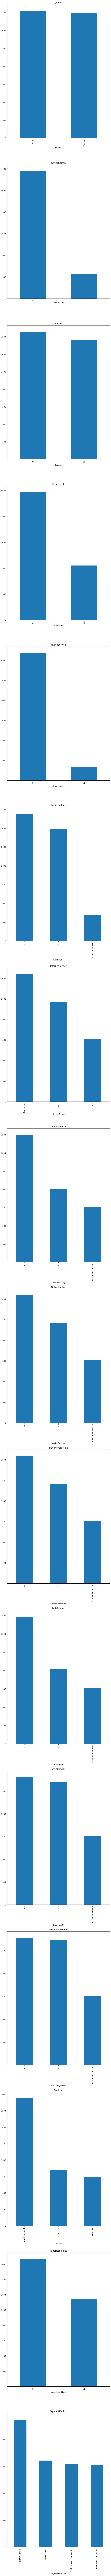

In [21]:
categorical_variables = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                         'PhoneService', 'MultipleLines', 'InternetService', 
                         'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

fig, ax = plt.subplots(len(categorical_variables), figsize=(10,250))
for element, i in zip(categorical_variables, range(len(categorical_variables))):
    df[element].value_counts().plot(kind='bar', ax=ax[i], title=element)

고객 유형 탐색
- 성별 : 남성, 여성의 수가 거의 비슷
- 시니어 : 시니어 말고도 젊은 고객이 일부 포함됨
- 배우자 : 배우자 유무의 수는 거의 비슷
- 부양가족 : 부양가족이 없는 고객이 더 많다.
- 전화서비스가 없는 고객의 대다수는 전화 서비스를 갖고 있는 고객보다 훨씬 더 많다.
- 인터넷 서비스는 주로 DSL이나 광섬유를 이용한다.
- MultipleLines, InternetService, OnlineSecurity, OnlineBackup, TechSupport  기능에 잘 엑세스하지 않는 것을 선호한다.
- 스트리밍 서비스는 선호하나, 안하나 고객 수가 거의 빕슷
- 년 계약보다 월 계약을 선호한다.
- 대부분은 종이가 없는 청구서를 선호하며 전자 수표와 같은 방식의 거래 방식을 사용한다.

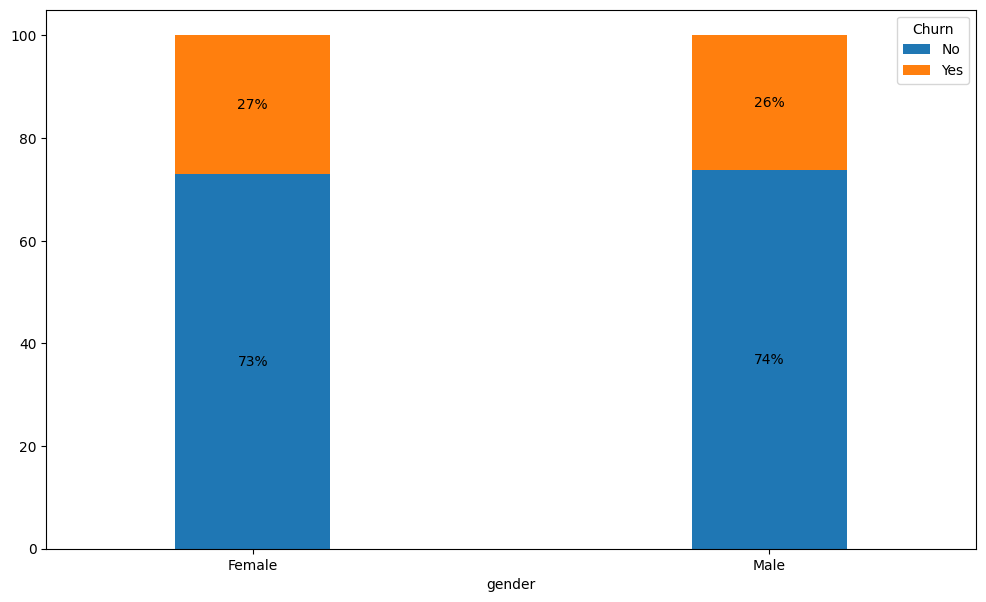

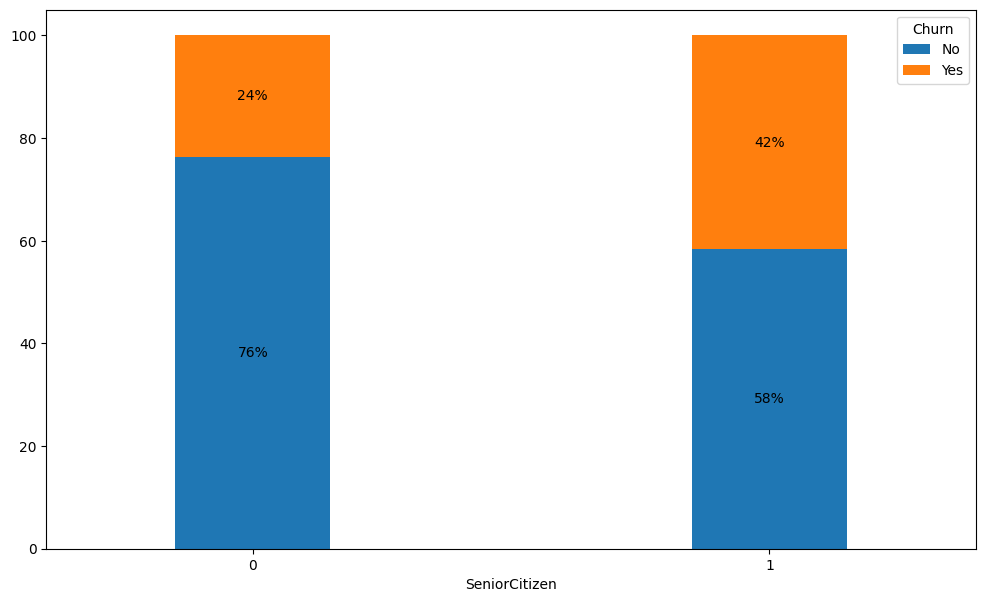

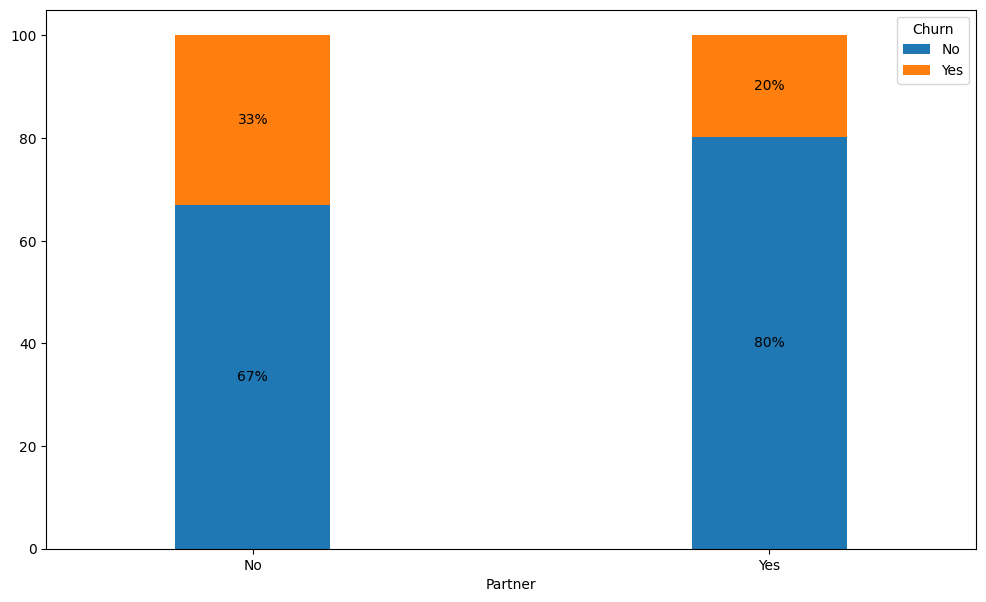

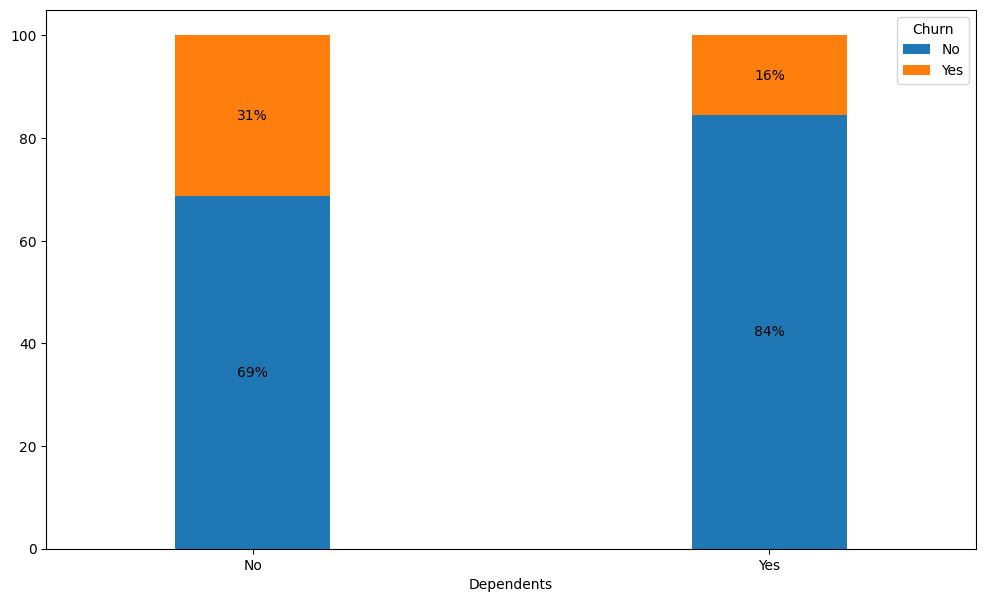

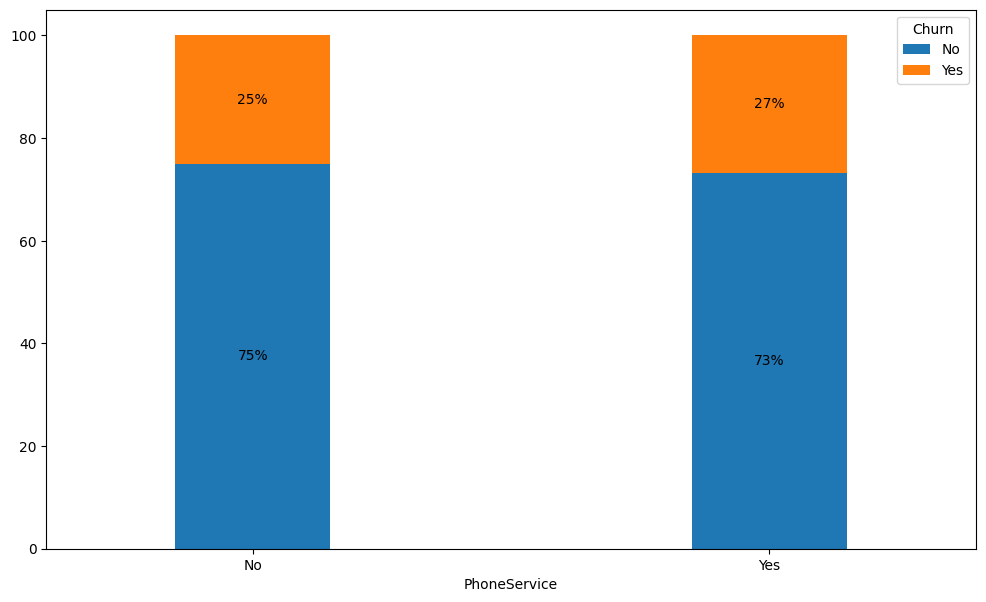

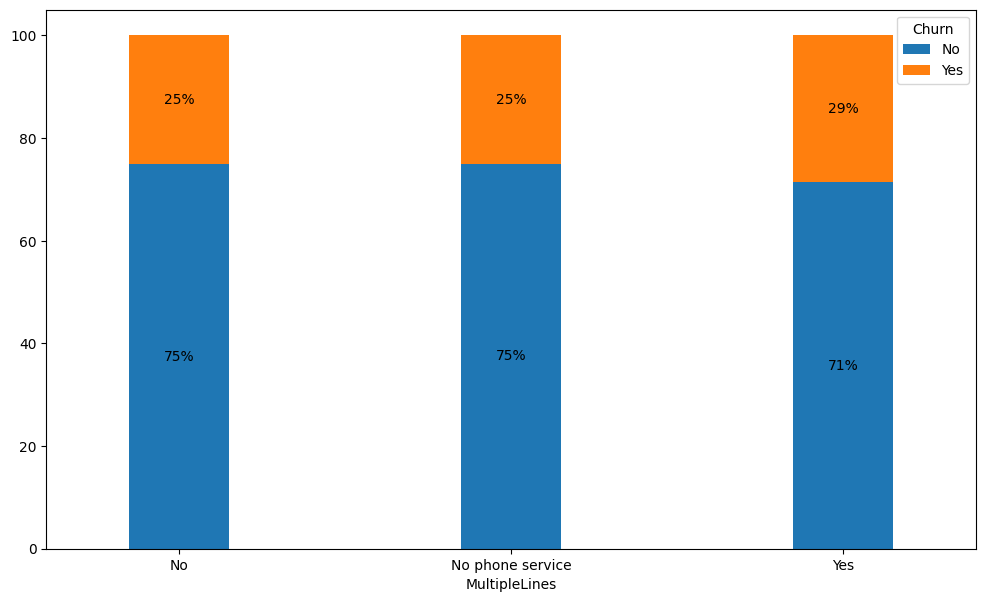

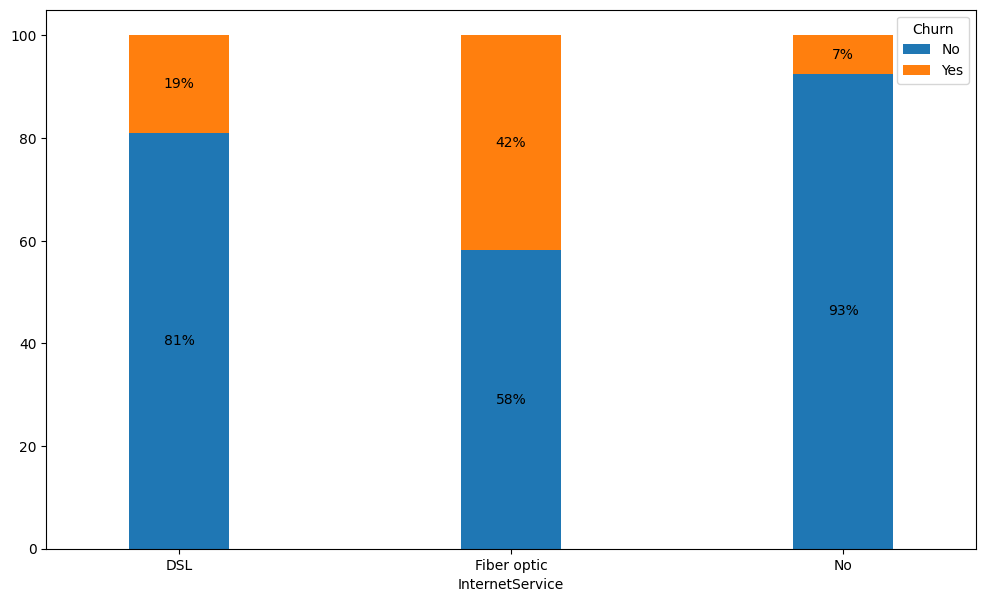

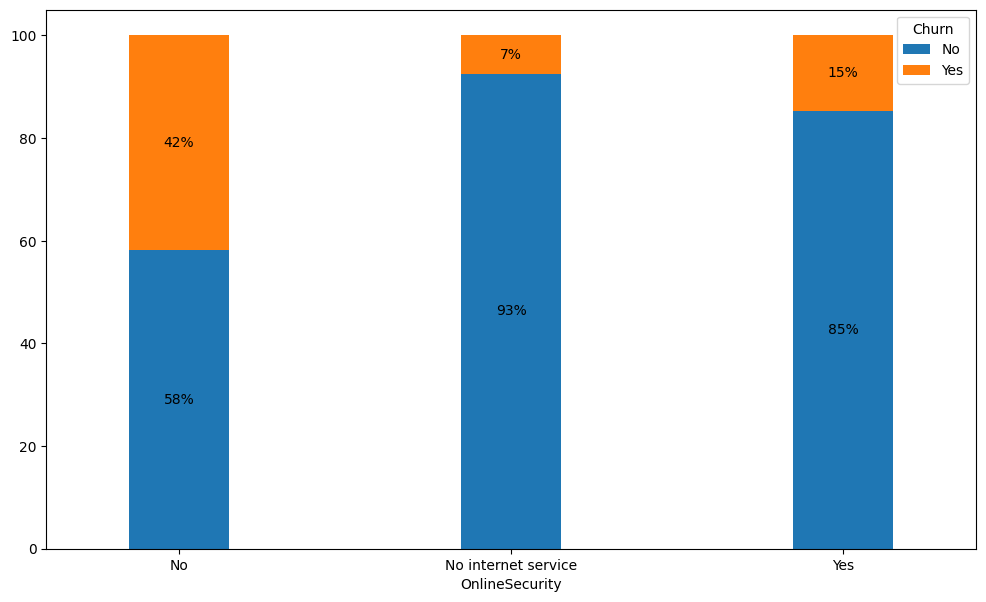

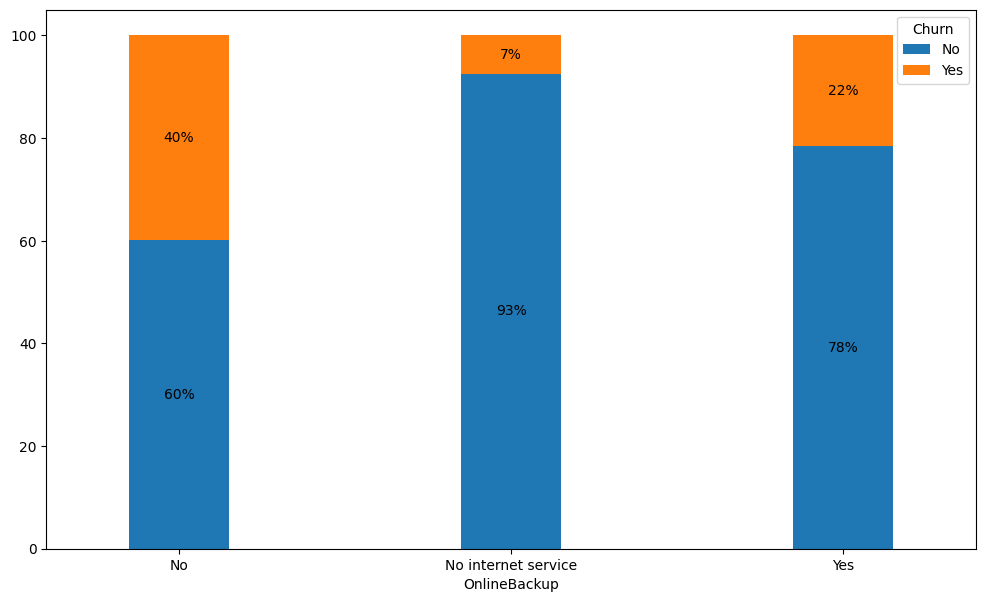

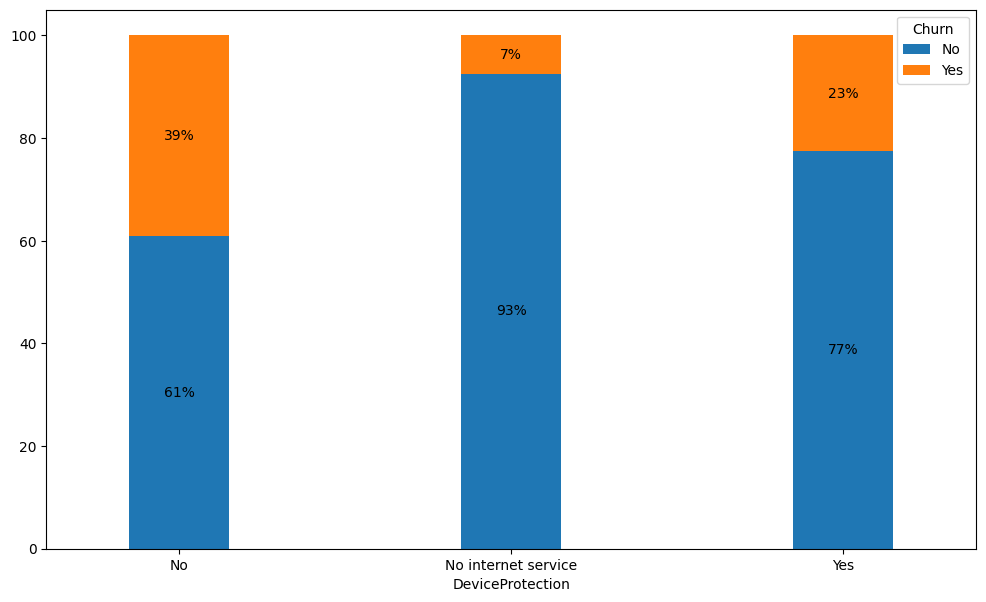

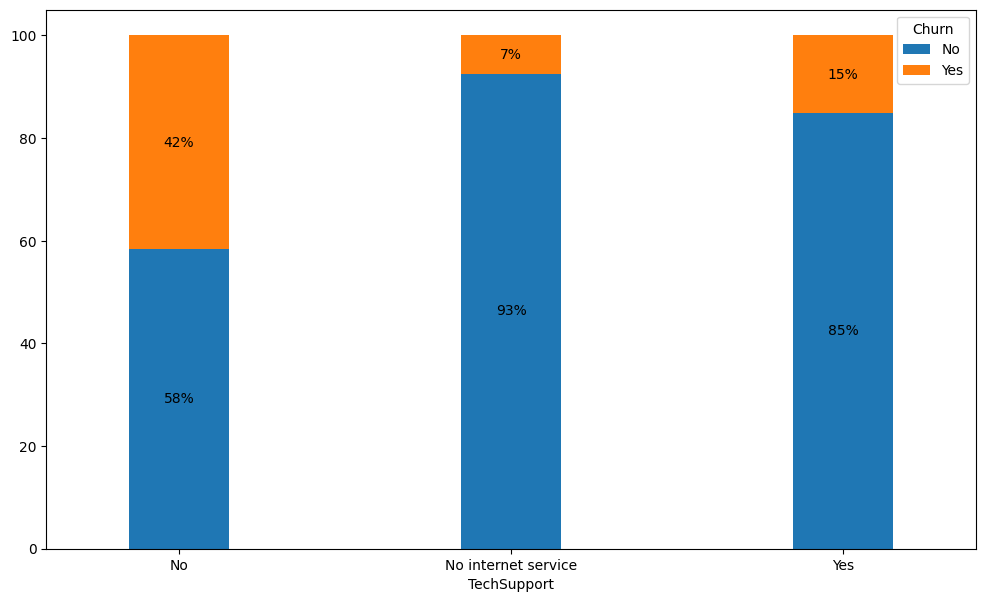

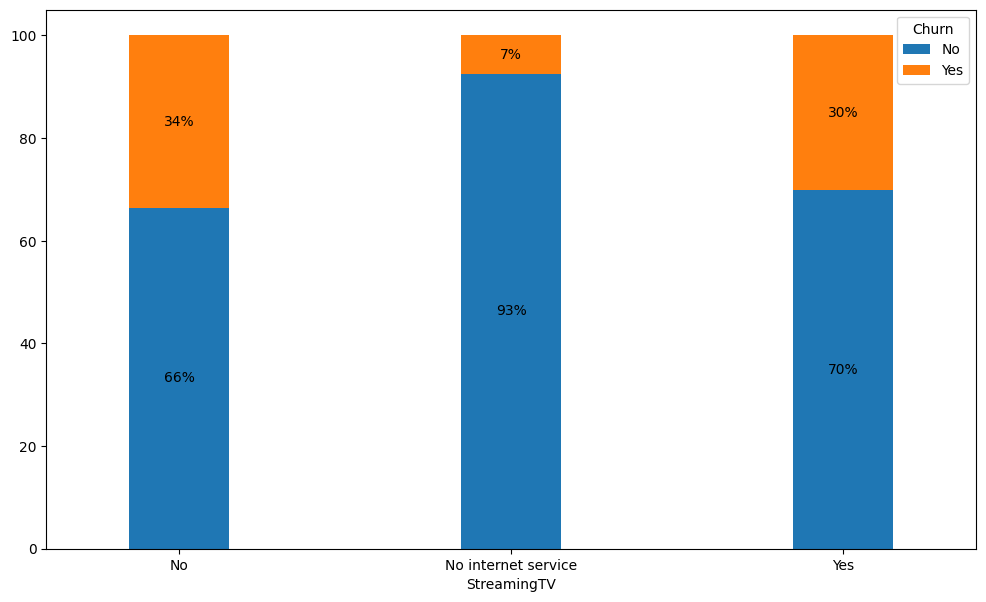

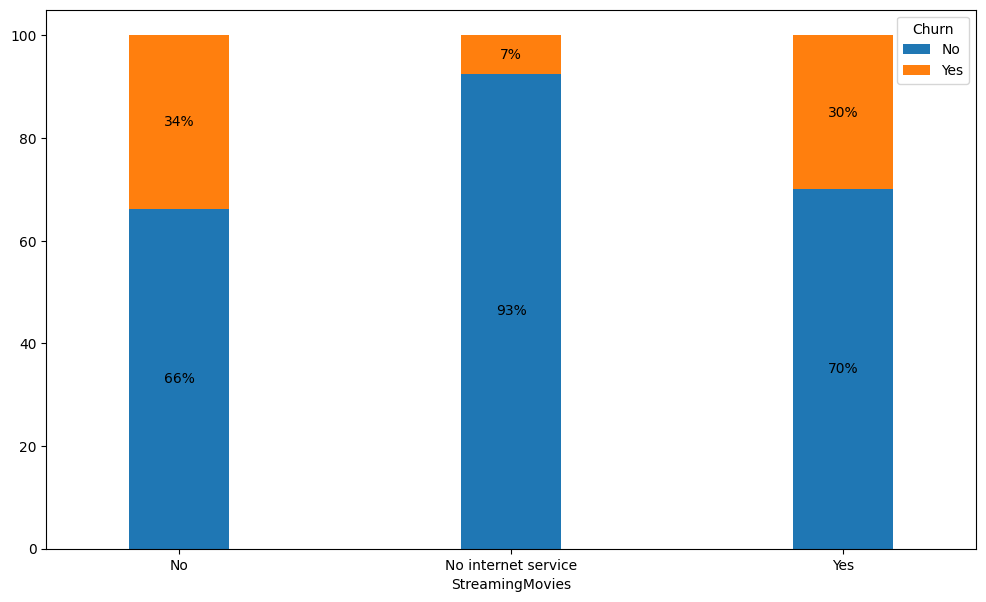

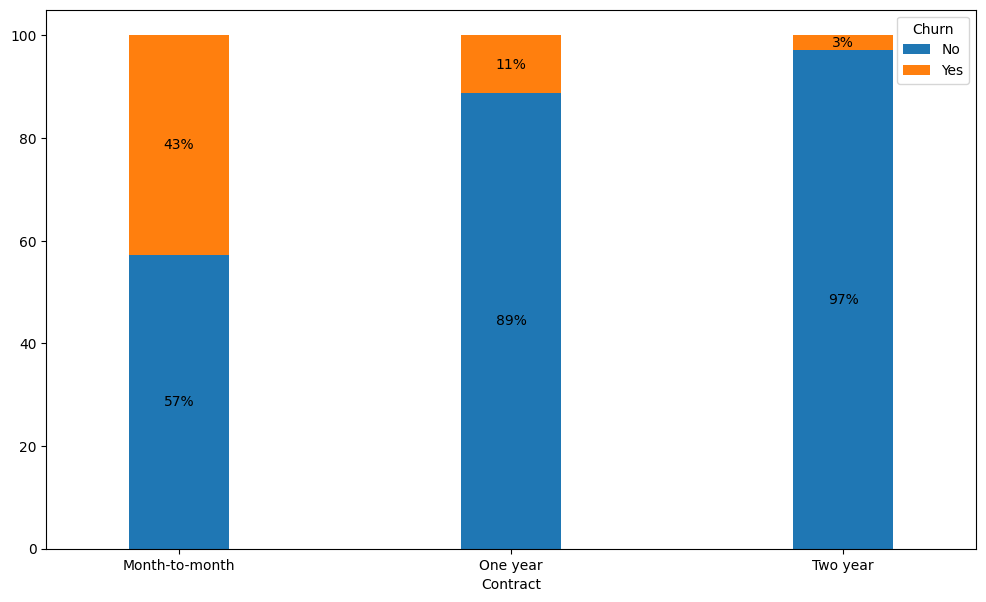

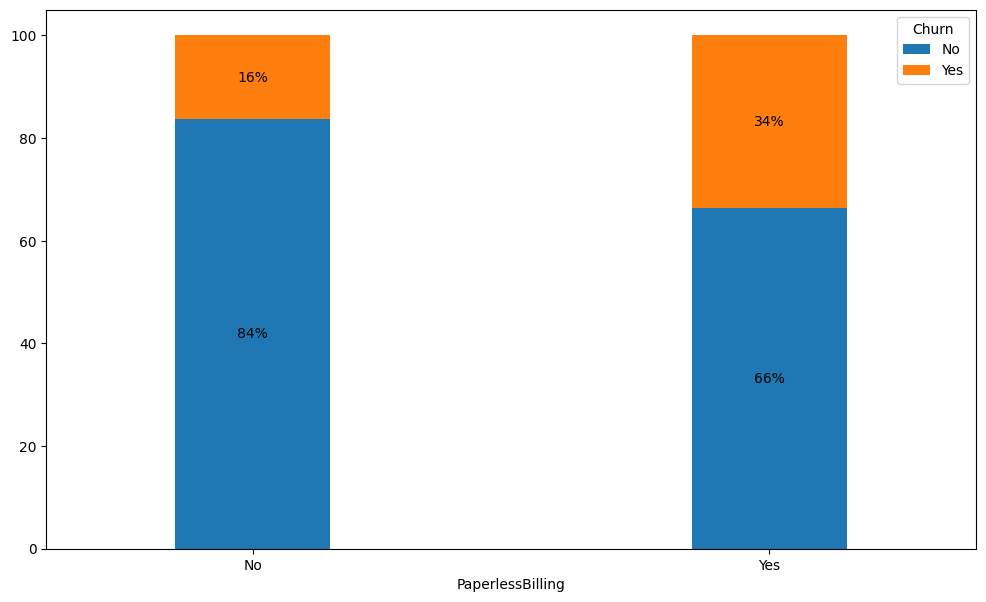

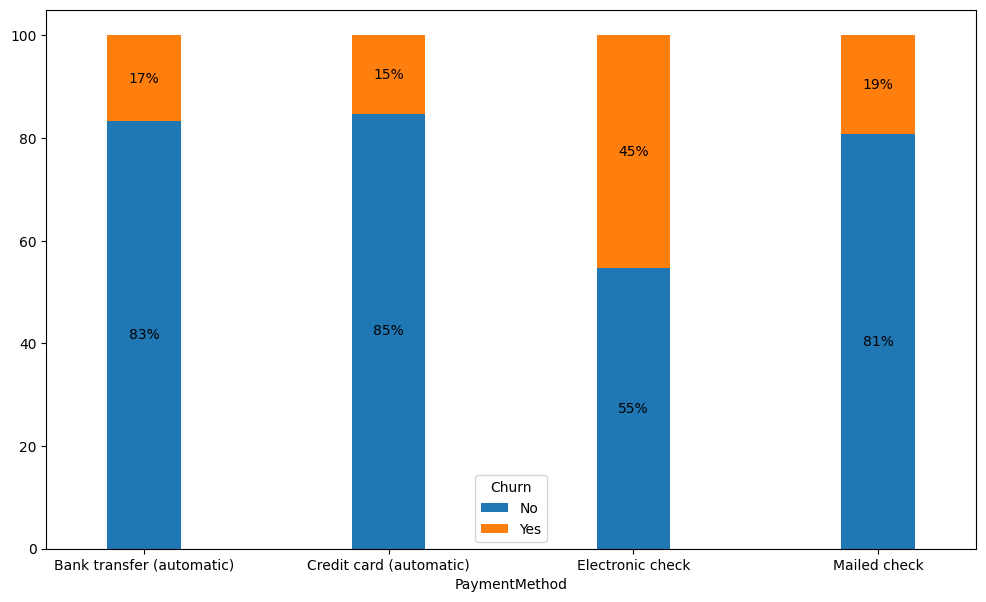

In [22]:
# 각 범주형 변수와 Churn 열을 그룹화한 후 size함수로 각 그룹의 크기를 계산하고 unstack으로 dataframe을 구성한다.
for i in range(len(categorical_variables)):
    counts = df.groupby([categorical_variables[i], 'Churn']).size().unstack()
    ax = (counts.T*100.0 / counts.T.sum()).T.plot(kind='bar', width = 0.3, rot=0, stacked=True, figsize=(12,7))
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x,y = p.get_xy()
        ax.text(x+width/2, y+height/2,
               '{:.0f}%'.format(height),
               horizontalalignment='center',
               verticalalignment='center')

- 성별: 남성, 여성 고객 모두 이탈하는 고객 수가 거의 같다.
- 시니어: 고령자에 비해 젊은 고객들이 이탈율이 더 높다.
- 배우자: 배우자가 없는 고객들의 이탈율이 더 높다.
- 부양가족이 없는 경우 이탈율이 더 높다.
- PhoneService와 MultipleLines 카테고리 전체에서 이탈고객은 동일한 비율을 나타냅니다.
- 광섬유를 InternetService로 사용하는 고객(빠른 인터넷 속도)은 다른 InternetService 방법(느린 인터넷 속도)에 비해 이탈률이 가장 높다.
- OnlineSecurity, OnlineBackup, OnlineProtection 및 TechSupport를 사용하지 않거나 갖고 있지 않은 고객은 나머지 그룹에 비해 이탈할 가능성이 더 높다.
- StreamingMovies와 StreamingTV 기능은 있으나 없으나 비슷한 이탈률을 보여줍니다.
- 년 계약보다 월별 계약한 고객이 이탈율이 높다.
- PaperlessBilling을 선호하는 고객은 그렇지 않은 고객보다 이탈 확률이 더 높다.
- 거래를 위해 ElectronicChecks를 사용하는 사람들은 그렇지 않은 사람들보다 더 이탈율이 높다.

#### feature간의 상관관계

<Axes: >

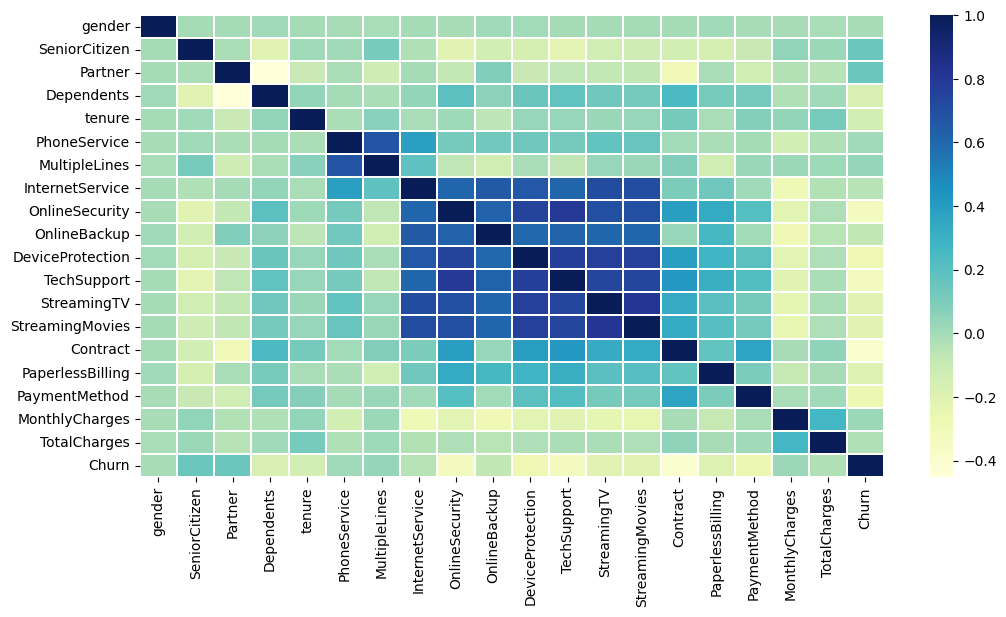

In [23]:
plt.figure(figsize=(12,6))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()  # 범주형 변수를 숫자로 변환하는 함수(0번 배열은 인코딩된 값을 갖고, 1번 배열은 고유값을 가짐.)
# mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, linewidth=.2, cmap='YlGnBu')

### 분석할 문제 정의
1. 어떤 고객 특성이 이탈 확률에 가장 큰 영향을 미치는가?
2. 고객 이탈을 예측하기 위한 가장 효과적인 모델은 무엇인가?
3. 고객 이탈을 감소시키기 위한 전략은 무엇인가?